# Modello bayesiano di regressione lineare bivariata
![](../../figures/art_52.png){ width=40% }

**Prerequisiti**

- Leggere *Regression and Other Stories* [@gelman2020regression].
  - Prestare particolare attenzione ai capitoli 6, "Background on Regression Modeling," e 7, "Linear Regression with a Single Predictor," che offrono una guida dettagliata al modello di regressione bivariato.

**Concetti e Competenze Chiave**

- Comprendere il significato del modello di regressione lineare bayesiano e le differenze rispetto al modello frequentista.
- Interpretare le stime dei parametri in un contesto bayesiano e confrontarle con l'interpretazione dei parametri nell'approccio frequentista.
- Comprendere il significato delle previsioni del modello di regressione nell'ambito bayesiano.
- Capire l'importanza e l'interpretazione del Posterior Predictive Check nel modello bayesiano.
- Capire il concetto di regressione verso la media.

**Preparazione del Notebook**

In [2]:
import os
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
from IPython import get_ipython
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import cmdstanpy
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel
import pingouin as pg

In [3]:
seed: int = sum(map(ord, "bayesian_bivariate_regression"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory
project_directory = os.path.join(home_directory, "_repositories", "psicometria")

## Introduzione {.unnumbered}

I modelli lineari sono stati utilizzati in varie forme per molto tempo. @stigler1986 descrive come il metodo dei minimi quadrati, una tecnica per adattare una semplice regressione lineare, fosse associato a problemi fondamentali in astronomia nel 1700, come la determinazione del moto della luna e la riconciliazione del moto non periodico di Giove e Saturno. All'epoca, gli astronomi erano tra i primi a sentirsi a proprio agio nell'utilizzare questi metodi, poiché raccoglievano personalmente le loro osservazioni e sapevano che le condizioni di raccolta dei dati erano simili, anche se i valori delle osservazioni differivano. Questo contrastava con l'approccio più cauto delle scienze sociali, dove la riluttanza a combinare dati eterogenei ritardava l'adozione dei modelli lineari [@stigler1986].

Come nota @alexander2023telling, quando costruiamo modelli, non stiamo scoprendo "la verità". Un modello non può essere una rappresentazione fedele della realtà. Utilizziamo i modelli per esplorare e comprendere i nostri dati. Non esiste un modello migliore in assoluto, ma solo modelli utili che ci aiutano a imparare qualcosa sui dati che abbiamo e, si spera, qualcosa sul mondo da cui sono stati generati. Quando utilizziamo i modelli, cerchiamo di comprendere il mondo, ma ci sono limiti alla prospettiva che portiamo in questo. Non dovremmo semplicemente inserire dati in un modello sperando che risolva tutto. Non lo farà.

> La regressione è in effetti un oracolo, ma un oracolo crudele. Parla per enigmi e si diletta nel punirci per aver posto domande sbagliate.
> 
> @McElreath_rethinking 

I modelli scientifici sono strumenti essenziali per comprendere la realtà che ci circonda. Il processo di creazione, esplorazione e analisi di questi modelli è fondamentale per approfondire la nostra conoscenza del mondo. Questo processo si può suddividere in diverse fasi:

1. Costruzione: Creiamo modelli basati sulle nostre attuali conoscenze e ipotesi.
2. Esplorazione: Studiamo le caratteristiche e le implicazioni dei modelli creati.
3. Verifica: Testiamo i modelli confrontandoli con dati reali e osservazioni.
4. Analisi critica: Cerchiamo di comprendere i limiti e le debolezze dei nostri modelli.
5. Revisione o sostituzione: Quando necessario, modifichiamo o abbandoniamo i modelli inadeguati.

È importante sottolineare che il valore principale di questo processo non risiede nel risultato finale, cioè nel modello stesso, ma nell'apprendimento e nella comprensione che otteniamo durante il percorso. Anche se a volte il modello finale può effettivamente rappresentare accuratamente la realtà, è il processo di sviluppo e analisi che ci fornisce intuizioni preziose.

Quando lavoriamo con i modelli, dobbiamo considerare due aspetti cruciali:

1. Il "mondo del modello": le assunzioni, le semplificazioni e le regole interne del modello stesso.
2. Il "mondo reale": la realtà più ampia e complessa che stiamo cercando di comprendere e descrivere.

È fondamentale riconoscere che i dati su cui basiamo i nostri modelli spesso non sono perfettamente rappresentativi della realtà. Questo può essere dovuto a limitazioni nella raccolta dei dati, bias nei campioni o semplicemente alla complessità del mondo reale. Di conseguenza, i modelli addestrati su questi dati, sebbene utili, non sono infallibili.

Come già rilevato nel @sec-scientific-method, per utilizzare efficacemente i modelli, dobbiamo porci costantemente due domande chiave:

1. In che misura il modello ci insegna qualcosa sui dati che abbiamo a disposizione?
2. Quanto accuratamente i dati che abbiamo riflettono il mondo reale su cui vogliamo trarre conclusioni?

Mantenere queste domande in primo piano ci aiuta a utilizzare i modelli in modo critico e consapevole, riconoscendone sia il potenziale che i limiti. Questo approccio ci permette di sfruttare al meglio i modelli come strumenti per comprendere il mondo, pur rimanendo consapevoli delle loro imperfezioni e delle sfide nella rappresentazione della realtà complessa.

L'evoluzione e l'applicazione dei metodi statistici moderni presentano un interessante caso di studio nell'adattamento degli strumenti scientifici a contesti in rapida evoluzione. Molti dei metodi statistici attualmente in uso trovano le loro radici in campi come l'astronomia e l'agricoltura. Un esempio emblematico è rappresentato da Ronald Fisher, figura di spicco nello sviluppo della statistica moderna, le cui opere seminali furono concepite durante il suo periodo presso un istituto di ricerca agricola.

Tuttavia, il panorama scientifico e tecnologico ha subito profondi cambiamenti dall'epoca di Fisher. L'applicazione di questi metodi statistici si è estesa a contesti che i loro ideatori difficilmente avrebbero potuto prevedere. Questa espansione solleva interrogativi cruciali sulla validità delle assunzioni fondamentali di questi metodi quando applicati in ambiti così diversi da quelli originari.

In conclusione, mentre la statistica rimane uno strumento di inestimabile valore, il suo utilizzo efficace richiede un equilibrio tra una solida conoscenza dei principi fondamentali e la flessibilità necessaria per adattarsi a scenari di ricerca in continua evoluzione. L'integrazione di metodologie diverse è essenziale per garantire l'affidabilità e la robustezza dei modelli statistici. Solo attraverso questo approccio olistico e adattativo possiamo sperare di comprendere e interpretare adeguatamente la complessità del mondo contemporaneo.

In questa sezione della dispensa, esploreremo due modelli statistici fondamentali: la regressione lineare bivariata e la regressione lineare multipla. La prima considera una sola variabile esplicativa, mentre la seconda ne include diverse. Per ciascun modello, esamineremo due approcci distinti:

1. L'utilizzo delle funzioni di `pingouin`, particolarmente utili per l'analisi esplorativa dei dati (EDA) quando si necessita di risultati rapidi.
2. L'approccio bayesiano, ideale quando l'obiettivo principale è l'inferenza statistica.

È importante sottolineare che i modelli statistici vengono utilizzati principalmente per due scopi: inferenza e previsione. Mentre la previsione si limita a descrivere l'associazione tra le variabili, l'inferenza mira a stabilire relazioni di causa-effetto attraverso l'uso del modello lineare. L'inferenza causale richiede una profonda conoscenza del fenomeno in esame e una progettazione sperimentale o quasi-sperimentale adeguata per giustificare le assunzioni necessarie.

Indipendentemente dall'approccio scelto, è fondamentale tenere presente che l'analisi di regressione è essenzialmente una forma di media ponderata. Di conseguenza, i risultati ottenuti riflettono inevitabilmente i bias e le peculiarità del dataset utilizzato.

## Modellare l'associazione statistica tra variabili

Per introdurre l'approccio bayesiano al modello di regressione, esamineremo un set di [dati](../../data/affect.csv) che riguarda la relazione tra i punteggi di affect e arousal. I dati provengono da due studi condotti nel Personality, Motivation and Cognition Laboratory della Northwestern University, in cui sono stati utilizzati film per indurre stati affettivi [@rafaeli2006premature].

Qui ci concentreremo sull'associazione tra l'ansia di stato, considerata come variabile indipendente, e la scala di Tense Arousal del *Motivational State Questionnaire* (MSQ), considerata come variabile dipendente.

In precedenza, abbiamo applicato il modello normale a una singola variabile. Tuttavia, di solito siamo interessati a modellare come una variabile di esito sia associata a una variabile predittiva. Se esiste un'associazione statistica tra la variabile predittiva e la variabile di esito, possiamo utilizzarla per predire il risultato. Quando la variabile predittiva è incorporata nel modello in un modo specifico, otteniamo una regressione lineare.

I dati dell'esempio sono forniti di seguito.

In [4]:
# Definire il percorso del file CSV
file_path = os.path.join(project_directory, "data", "affect.csv")

# Leggere il file CSV in un DataFrame pandas
data = pd.read_csv(file_path)

# Selezionare le colonne state1 e TA1
df = data[["state1", "TA1"]]
df.head()

,state1,TA1
0,41,11.0
1,26,5.0
2,31,8.0
3,28,8.0
4,47,12.0


L'associazione tra le due variabili, ansia di stato e Tense Arousal, è rappresentata nel grafico sottostante. Il grafico suggerisce che l'associazione può essere approssimata da una semplice funzione matematica, come una retta. Tuttavia, è evidente che una funzione lineare sia troppo semplicistica per rappresentare accuratamente questi dati, poiché non è possibile trovare una singola retta che passi per tutti i punti del diagramma di dispersione.

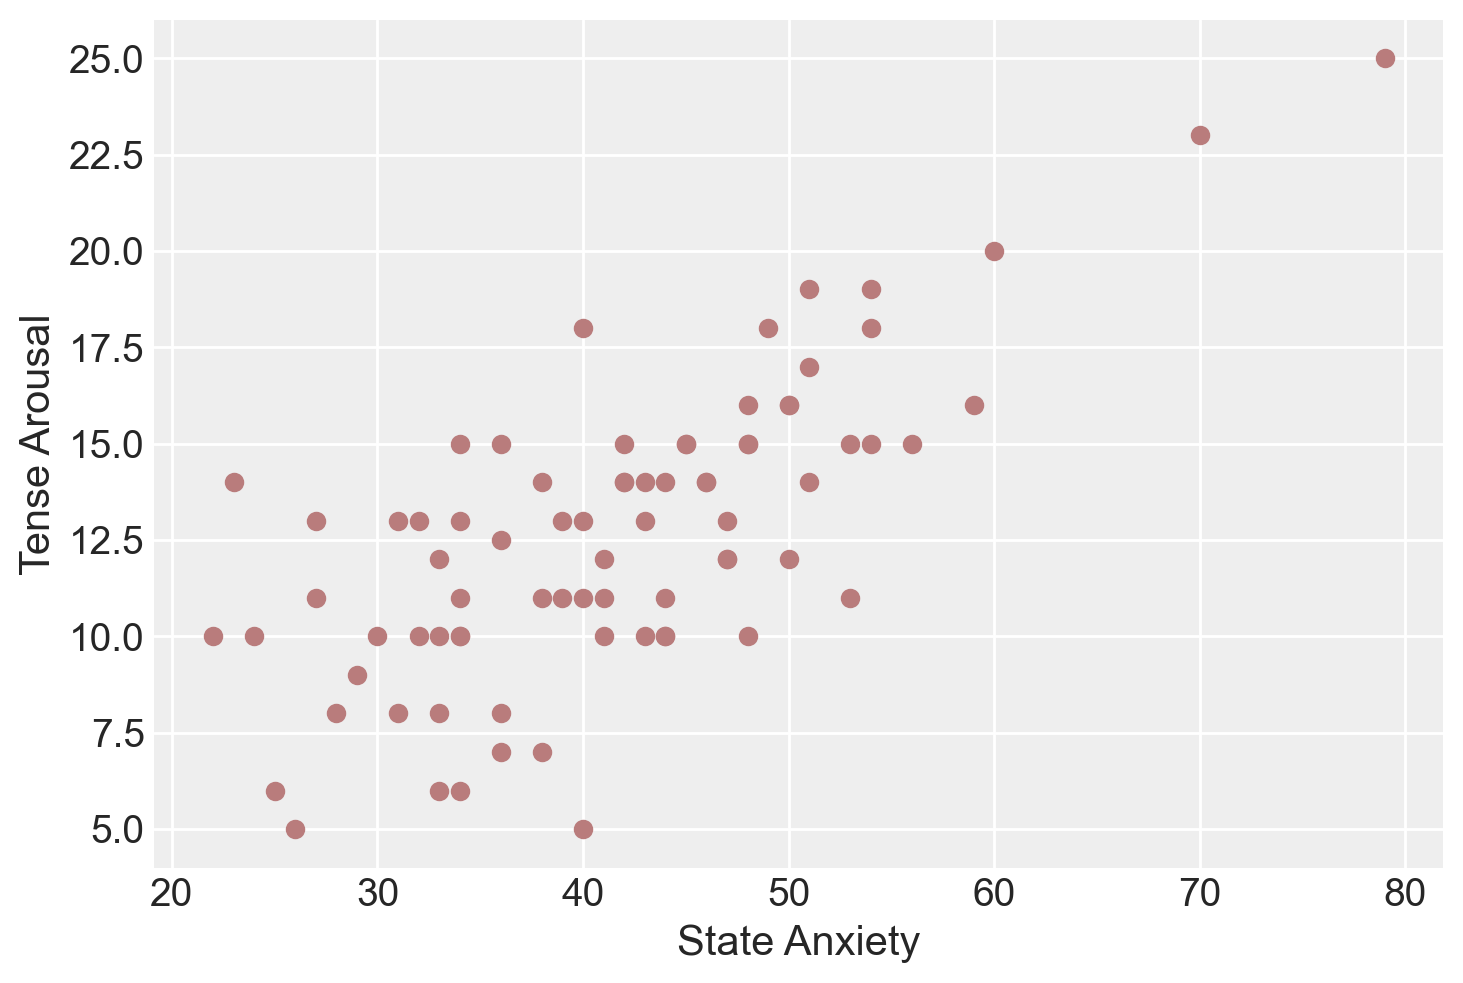

In [5]:
color_fill = "#b97c7c"
plt.scatter(df["state1"], df["TA1"], color=color_fill)
plt.xlabel("State Anxiety")
plt.ylabel("Tense Arousal")
plt.show()

## Modello Generativo dei Dati

Per descrivere la relazione tra ansia di stato e Tense Arousal, utilizzeremo un modello statistico lineare. Assumeremo che la relazione media tra $x$ (ansia di stato) e $y$ (Tense Arousal) possa essere rappresentata da una retta, ma influenzata da un certo grado di errore. Supponiamo che questo errore sia costante ai vari livelli di $x$ e segua una distribuzione Normale. Inoltre, presupponiamo che gli errori attorno alla retta di regressione siano indipendenti tra loro.

In questo contesto, le nostre assunzioni delineano un modello statistico lineare, formalizzato come segue:

$$ y_i = \alpha + \beta x_i + \epsilon_i $$

dove:

- $\alpha$ è l'intercetta,
- $\beta$ è il coefficiente angolare,
- $\epsilon_i \sim \text{Normale}(0, \sigma^2)$ rappresenta l'errore, con media zero e varianza costante $\sigma^2$.

Queste assunzioni ci permettono di applicare metodi di regressione lineare per stimare i parametri del modello ($\alpha$ e $\beta$) e quantificare l'incertezza delle predizioni, considerando la variabilità nei dati.

Il modello lineare descritto sopra costituisce il modello generativo dei dati (verosimiglianza):

$$ y_i = \alpha + \beta x_i + \epsilon_i,  \quad i \in 1, \dots N $$

o equivalentemente

$$ \epsilon_n \sim \text{Normale}(0, \sigma) $$

Questo modello descrive come i dati $y$ sono generati. Ogni osservazione $y_i$ è una combinazione lineare di una costante $\alpha$ (intercetta), un coefficiente $\beta$ che moltiplica il valore della variabile $x$ (ansia di stato), e un termine di errore $\epsilon_n$ che cattura la variabilità non spiegata dal modello lineare.

Il termine di errore $\epsilon_i$ è distribuito secondo una distribuzione normale con media 0 e deviazione standard $\sigma$. Questo implica che l'errore è simmetricamente distribuito attorno a zero e ha una variabilità definita da $\sigma$.

L'equazione

$$ y_i \sim \text{Normale}(\alpha + \beta x_i, \sigma), \quad i \in 1, \dots N $$

mostra come il valore osservato $y_i$ segue una distribuzione normale con media $\alpha + \beta x_i$ e deviazione standard $\sigma$. Questo significa che, dato $x_i$, i valori di $y_i$ sono distribuiti normalmente attorno alla retta di regressione definita da $\alpha + \beta x_i$.

Consideriamo il caso in cui $y_i$ rappresenta Tense Arousal e $x_i$ rappresenta l'ansia di stato. Secondo il nostro modello:

- $\alpha$ è l'intercetta, ovvero il valore atteso di Tense Arousal quando l'ansia di stato è zero.
- $\beta$ è il coefficiente che indica quanto aumenta (o diminuisce) Tense Arousal per ogni aumento di un punto dell'ansia di stato.
- $\sigma$ è la deviazione standard che misura la variabilità di Tense Arousal attorno alla media prevista dal modello.

Questo modello ci consente di stimare l'effetto dell'ansia di stato su Tense Arousal e di quantificare l'incertezza associata a queste stime.

## Modello Bayesiano della Regressione Bivariata

### Verosimiglianza

Assumiamo la verosimiglianza che abbiamo descritto in precedenza:

$$ y \sim \text{Normale}(\alpha + \beta x, \sigma) $$

Questo significa che i dati $y$ seguono una distribuzione normale con media $\alpha + \beta x$ e deviazione standard $\sigma$. In altre parole, il valore osservato $y$ è generato come una combinazione lineare di $\alpha$ (intercetta), $\beta$ (coefficiente della variabile $x$), più un errore che segue una distribuzione normale con deviazione standard $\sigma$.

### Distribuzioni a Priori

In una prima versione del modello, useremo delle distribuzioni a priori uniformi per i tre parametri.

### Distribuzioni a Posteriori

Le distribuzioni a priori vengono combinate con i dati osservati attraverso il teorema di Bayes per aggiornare le nostre credenze sui parametri del modello. Il risultato è una distribuzione a posteriori per ciascun parametro che riflette sia l'informazione contenuta nei dati che le credenze iniziali incorporate nelle distribuzioni a priori. 

### Codice Stan

Il codice Stan che implementa il modello precedente è contenuto nel file `arousal_model_1.stan`. Compiliamo e stampiamo il modello.

In [70]:
stan_file = os.path.join(project_directory, 'stan', 'arousal_model_1.stan')
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}



Si osservi che, in questa prima istanziazione del modello bayesiano, non avendo specificato le distribuzioni a priori per i parametri $\alpha$, $\beta$ e $\sigma$, Stan assume distribuzioni a priori uniformi per questi parametri.

### Dizionario con i dati

Sistemiamo i dati in un dizionario come richiesto dal modello Stan.

In [71]:
stan_data = {
    "N": len(df["TA1"]),
    "x": df["state1"],
    "y": df["TA1"]
}
print(stan_data)

{'N': 78, 'x': 0     41
1     26
2     31
3     28
4     47
      ..
73    40
74    60
75    24
76    33
77    33
Name: state1, Length: 78, dtype: int64, 'y': 0     11.0
1      5.0
2      8.0
3      8.0
4     12.0
      ... 
73    13.0
74    20.0
75    10.0
76    10.0
77     6.0
Name: TA1, Length: 78, dtype: float64}


### Campionamento MCMC

Eseguiamo il campionamento MCMC.

In [72]:
fit = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

### Distribuzioni a posteriori

Esaminiamo le distribuzioni a posteriori dei parametri.

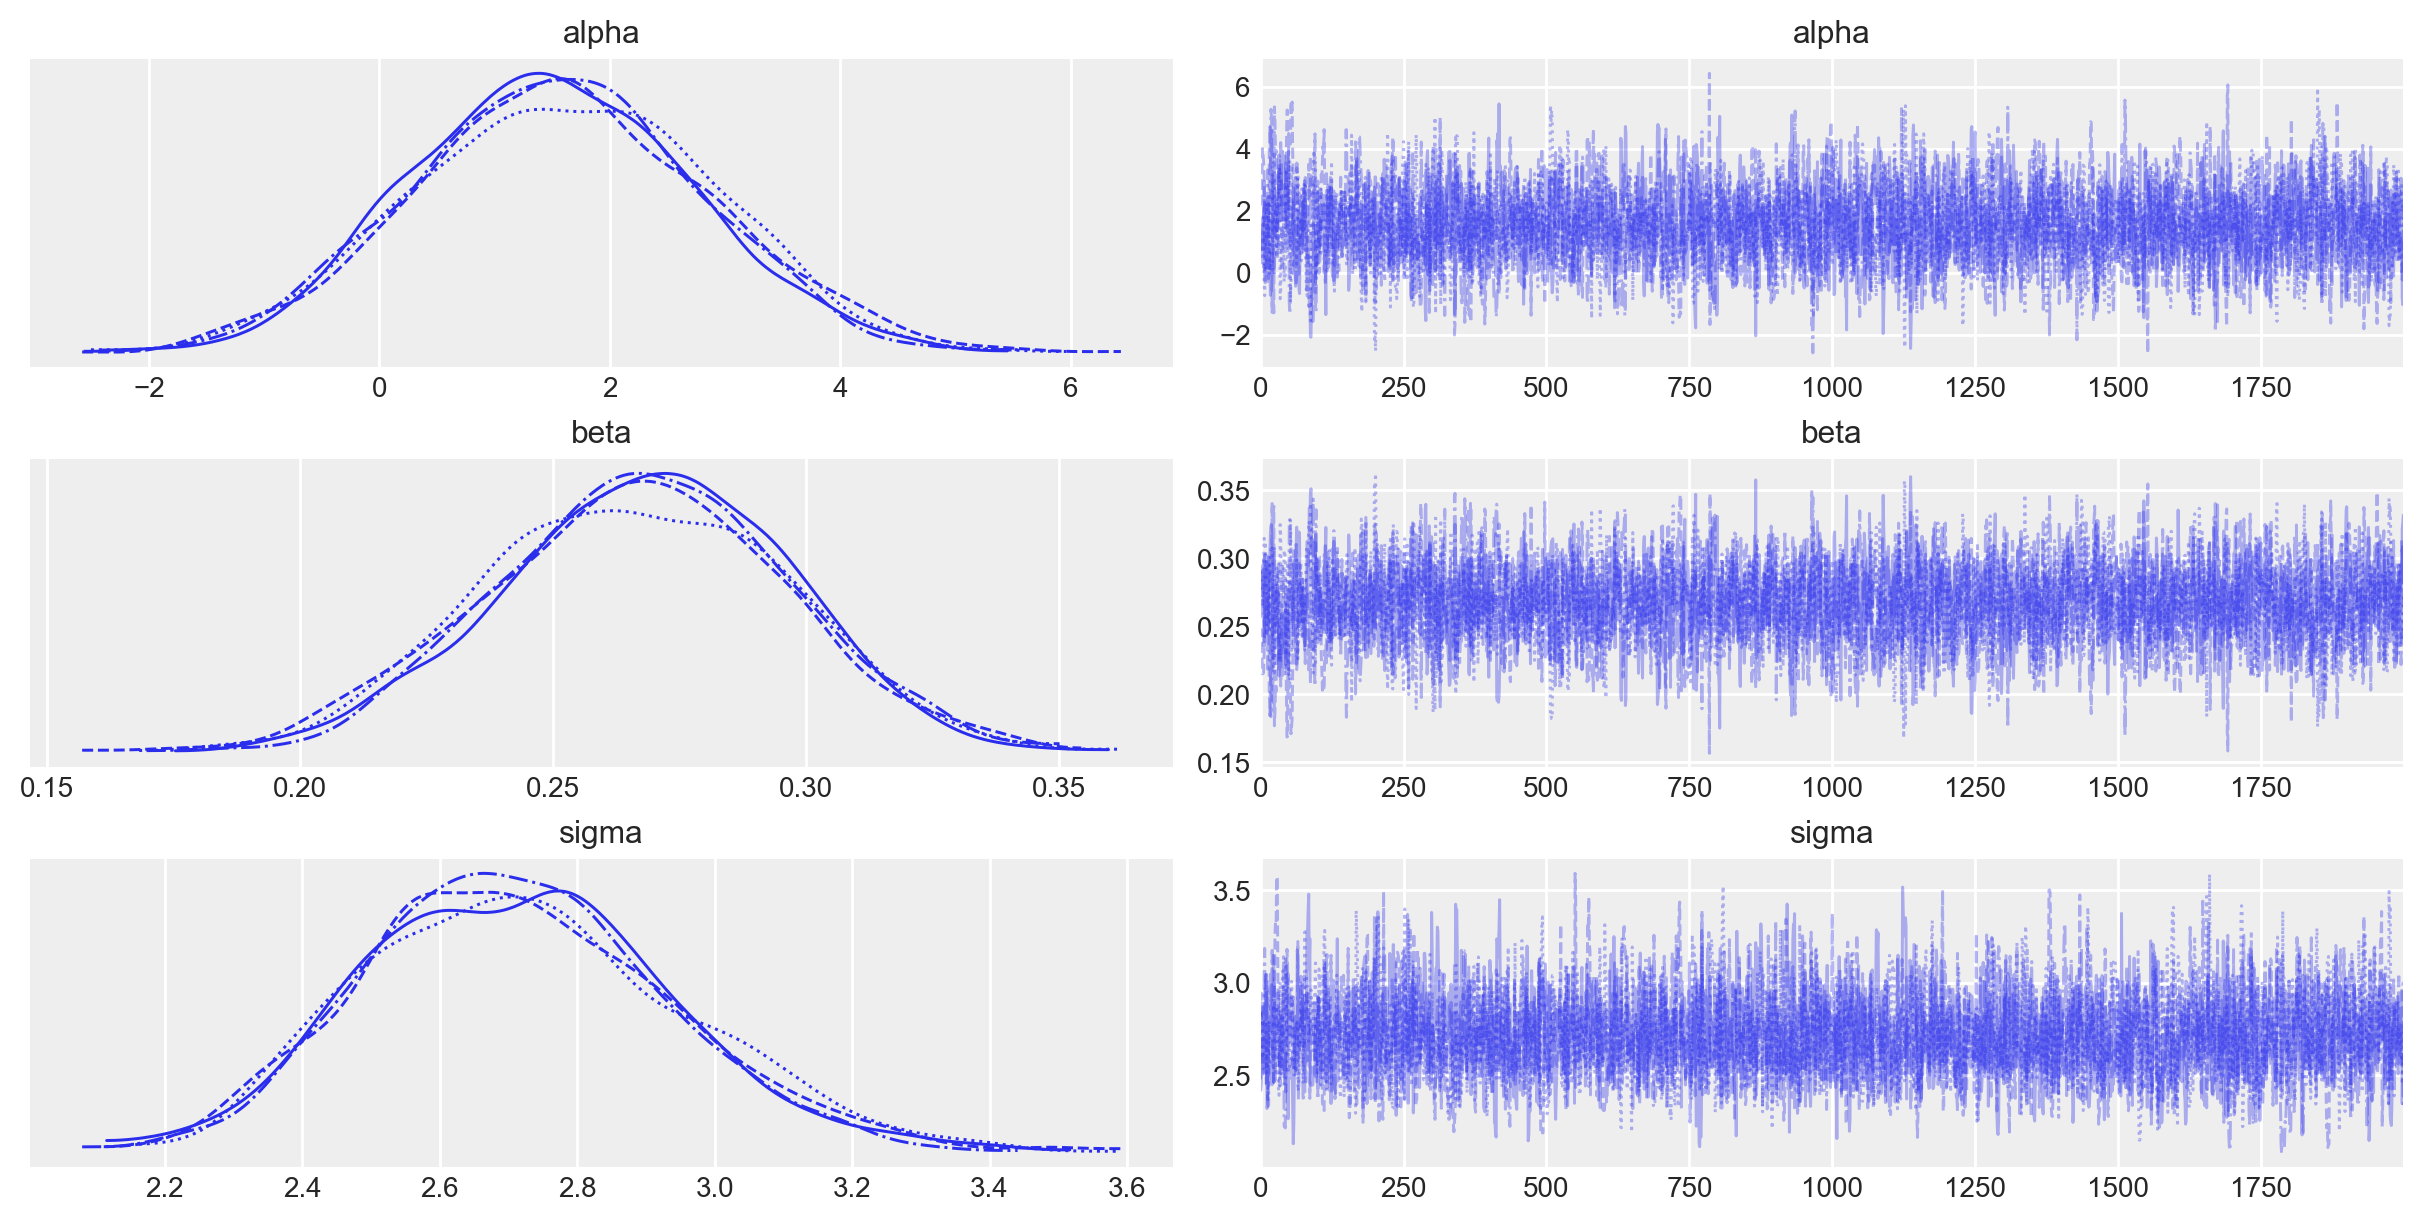

In [73]:
_ = az.plot_trace(fit, var_names=(["alpha", "beta", "sigma"]))

Le tracce delle quattro catene indicano che sono ben mescolate e convergono verso una distribuzione stazionaria, segnalando una buona esplorazione dello spazio dei parametri. Questo è evidenziato dal fatto che le tracce non mostrano trend evidenti e oscillano intorno a un valore centrale, suggerendo che le catene hanno raggiunto l'equilibrio.

La forma della distribuzione a posteriori, visibile nei grafici a densità, appare approssimativamente gaussiana per ciascun parametro (`alpha`, `beta`, e `sigma`). Questo suggerisce che, dato il modello e i dati, le stime a posteriori sono stabili e ben definite, con una concentrazione delle probabilità attorno ai valori medi e una simmetria che riflette una distribuzione normale.

In sintesi, i grafici di traccia indicano una buona convergenza e una distribuzione a posteriori stabile e ben definita, rafforzando la fiducia nelle stime bayesiane ottenute.

### Sintesi delle Distribuzioni a Posteriori

L'oggetto `fit` generato da `cmdstanpy` appartiene alla classe `cmdstanpy.stanfit.mcmc.CmdStanMCMC`. Questo oggetto è funzionalmente equivalente a un oggetto della classe `InferenceData`, consentendo la sua manipolazione tramite le funzioni offerte da ArviZ. Procediamo quindi con l'esame di un sommario delle distribuzioni a posteriori dei parametri del modello lineare.

In [74]:
az.summary(fit, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.552,1.256,-0.859,3.816,0.026,0.019,2395.0,2748.0,1.0
beta,0.267,0.029,0.213,0.323,0.001,0.000,2436.0,2858.0,1.0
sigma,2.716,0.227,2.314,3.149,0.004,0.003,3410.0,3273.0,1.0


- **Alpha (Intercetta):** La stima media di `alpha` è 1.552, con un intervallo di credibilità (HDI - Highest Density Interval) al 3% e 97% che va da -0.859 a 3.816. Questo significa che, date le informazioni disponibili e il modello specificato, c'è una probabilità del 94% che l'intercetta reale si trovi all'interno di questo intervallo. L'intercetta corrisponde al valore atteso di Tense Arousal quando l'ansia di stato vale 0.
  
- **Beta (Coefficiente angolare):** La stima media di `beta` è 0.267. Anche qui, l'intervallo di credibilità al 94% va da 0.213 a 0.323, suggerendo che è molto probabile che l'effetto del predittore `x` sulla variabile di risposta `y` sia positivo e compreso in questo intervallo. La pendenza $\beta$ ci informa sull'incremento atteso di Tense Arousal quando l'ansia di stato aumenta di un'unità.

- **Sigma (Deviazione standard residua):** La stima media di `sigma` è 2.716, con un intervallo di credibilità da 2.314 a 3.149. Questa è una misura della variabilità residua, ovvero la deviazione standard degli errori rispetto alla linea di regressione.

La colonna `mean` dell'output riporta la media della distribuzione a posteriori di ciasccun parametro, mentre nella colonna `sd` troviamo una misura di dispersione della distribuzione a posteriori del parametro, ovvero la quantificazione dell'intertezza della stima a posteriori. In pratica è la deviazione standard della distribuzione a posteriori, ovvero la radice quadrata della varianza dei campioni della distribuzione a posteriori del parametro.

Supponiamo di avere $S$ campioni per il parametro $\theta$. Questi campioni possono essere denotati come $\theta_1, \theta_2, \dots, \theta_S$. La media campionaria (o stima puntuale bayesiana) del parametro $\theta$ si calcola come:

$$
\bar{\theta} = \frac{1}{S} \sum_{i=1}^{S} \theta_i.
$$

La deviazione standard della distribuzione a posteriori, che è ciò che è indicato con `sd`, si calcola come la radice quadrata della varianza campionaria dei campioni posteriori:

$$
\text{Var}(\theta) = \frac{1}{S-1} \sum_{i=1}^{S} (\theta_i - \bar{\theta})^2,
$$

$$
\text{sd}(\theta) = \sqrt{\text{Var}(\theta)}.
$$

In sintesi, `sd` è calcolato come la deviazione standard dei campioni ottenuti dalla distribuzione a posteriori di un parametro.

Le altre colonne sono le seguenti.

- **HDI (Intervallo di Massima Densità):** Questo intervallo rappresenta la regione più densa dell'intera distribuzione a posteriori, contenente il 94% delle probabilità. È l'equivalente bayesiano dell'intervallo di confidenza, ma con un'interpretazione probabilistica diretta.

- **R_hat:** È un indicatore di convergenza per le catene di Markov Monte Carlo (MCMC). Un valore di `R_hat` prossimo a 1 segnala che la catena è probabilmente convergente, suggerendo che le stime a posteriori sono affidabili.

- **ESS (Dimensione Campionaria Effettiva):** Indica l'equivalente di un campione indipendente in un'analisi MCMC, valutando quanto efficacemente i campioni generati dalla catena rappresentano la distribuzione a posteriori.

Infine, `mcse_mean` che `mcse_sd` sono misure che valutano la precisione delle stime ottenute tramite MCMC, quantificando quanto queste stime possono variare a causa della natura stocastica del processo di campionamento.

- **mcse_mean (Monte Carlo Standard Error of the Mean):** Questo valore rappresenta l'errore standard Monte Carlo associato alla stima della media del parametro. In altre parole, `mcse_mean` quantifica l'incertezza introdotta dal processo di campionamento MCMC stesso. Un valore basso indica che la catena di Markov Monte Carlo ha fornito una stima della media del parametro con un'alta precisione.

- **mcse_sd (Monte Carlo Standard Error of the Standard Deviation):** Analogamente, `mcse_sd` è l'errore standard Monte Carlo associato alla stima della deviazione standard della distribuzione a posteriori del parametro. Questo valore misura l'incertezza nella stima della dispersione del parametro, dovuta al processo di campionamento MCMC. Anche qui, un valore basso indica che la stima della deviazione standard è stabile e precisa.

Possiamo confrontare i valori ottenuti con l'approccio bayesiano con quelli trovati usando la procedura di massima verosimiglianza.

In [75]:
lm = pg.linear_regression(df["state1"], df["TA1"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.56,1.25,1.25,0.22,0.52,0.52,-0.93,4.04
1,state1,0.27,0.03,9.14,0.00,0.52,0.52,0.21,0.33


La somiglianza tra le due soluzioni indica che, quando usiamo dei prior uniformi per i parametri,  i due approcci producono risultati sostanzialmente equivalenti.

L'interpretazione del significato dei parametri è la stessa anche per l'approccio frequentista: 

- L'intercetta rappresenta il valore atteso della variabile di risposta `TA1` quando il predittore `state1` è pari a zero. 
- Il coefficiente `beta` rappresenta la variazione attesa nella variabile di risposta `TA1` per ogni unità di incremento in `state1`. 

Ci sono però delle differenze sostanziali nell'interpretazione dell'incertezza associata alle stime dei parametri.

- **Stima Puntuale vs Distribuzione a Posteriori:**
  - **Frequentista:** Le stime di `alpha` e `beta` sono considerate come valori puntuali, ottenuti attraverso il metodo dei minimi quadrati. Gli errori standard associati a queste stime forniscono un'indicazione della variabilità delle stime se ripetessimo il campionamento molte volte.
  - **Bayesiano:** Le stime di `alpha` e `beta` sono presentate come distribuzioni a posteriori. La media di queste distribuzioni può essere considerata la stima puntuale, ma l'intera distribuzione riflette la nostra incertezza attorno a queste stime, basata sia sui dati osservati che sulle informazioni a priori.

- **Intervallo di Confidenza vs Intervallo Credibile:**
  - **Frequentista:** L'intervallo di confidenza al 95% indica che, se ripetessimo l'esperimento molte volte, il 95% di tali intervalli conterrà il vero valore del parametro. Questo intervallo si basa sulla stima puntuale e sull'assunzione di distribuzione normale degli errori.
  - **Bayesiano:** L'intervallo credibile al 94% (ad esempio l'HDI - Highest Density Interval) rappresenta la probabilità che il parametro si trovi entro quell'intervallo dato il modello, i dati osservati e le informazioni a priori. È un'intervallo che ha una diretta interpretazione probabilistica.

- **p-value vs Significato Bayesiano:**
  - **Frequentista:** Il p-value è utilizzato per testare l'ipotesi nulla che il coefficiente sia uguale a zero. Un p-value molto basso (come in questo caso per `beta`) suggerisce che c'è una forte evidenza contro l'ipotesi nulla.
  - **Bayesiano:** In un'analisi bayesiana, non si fa riferimento a p-value; l'accento è posto sulla distribuzione a posteriori e sull'intervallo credibile, che forniscono una comprensione diretta dell'incertezza attorno ai parametri senza bisogno di test di ipotesi tradizionali.

In sintesi,

- **Interpretazione delle stime:** Nell'approccio frequentista, le stime dei parametri sono valori puntuali accompagnati da un intervallo di confidenza che riflette la variabilità campionaria. Nell'approccio bayesiano, ogni parametro è rappresentato come una distribuzione a posteriori che incorpora sia i dati osservati sia le informazioni a priori.
  
- **Gestione dell'incertezza:** L'approccio frequentista usa errori standard e intervalli di confidenza, mentre l'approccio bayesiano utilizza l'intera distribuzione a posteriori per descrivere l'incertezza.
- **Probabilità e significatività:** Nell'approccio frequentista, il p-value è cruciale per determinare la significatività statistica, mentre nell'approccio bayesiano si utilizza l'intervallo credibile e la probabilità a posteriori per descrivere quanto è probabile un parametro dato i dati e le informazioni a priori.

## Interpretare i coefficienti di regressione come confronti, non come effetti

@gelman2021regression sottolineano che i coefficienti di regressione sono spesso chiamati "effetti", ma questa terminologia può essere fuorviante. Gli effetti, infatti, sono conseguenze di una relazione causale. Tuttavia, ciò che il modello di regressione stima non è necessariamente un effetto causale, ma piuttosto un pattern osservazionale. In particolare, quello che viene osservato è che la media della variabile $y$ nella sottopopolazione con $X = x + 1$ è $b$ volte maggiore o minore (a seconda del segno di $\beta$) rispetto alla media della sottopopolazione con $X = x$.

La regressione è uno strumento matematico utilizzato principalmente per fare previsioni. I coefficienti di regressione devono essere sempre interpretati come confronti medi. Solo in circostanze specifiche, quando la regressione descrive un processo causale ben definito, è possibile interpretarli come effetti. Tuttavia, questa interpretazione causale deve essere giustificata dal disegno dello studio e non può essere derivata unicamente dall'uso del modello statistico.

## Predizione

La distribuzione a posteriori non fornisce solo informazioni sui singoli parametri, ma anche sulle loro interdipendenze. Queste relazioni sono riflesse nei campioni a posteriori, che possono essere trasformati in vari modi. Ad esempio, possiamo calcolare la predizione a posteriori del modello lineare per il valore atteso di Tense Arousal quando l'ansia di stato è pari a 30 usando il seguente comando nel blocco `generated quantities`:

`pred = alpha + beta * 30;`

Modifichiamo il modello Stan per aggiungere questo comando nel blocco `generated quantities` e compiliamo il modello.

In [76]:
stan_file = os.path.join(project_directory, "stan", "arousal_model_2.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}
generated quantities {
  real pred; // predizione
  
  pred = alpha + beta * 30;
}



In questo modello Stan aggiornato, il blocco `generated quantities` calcola la predizione a posteriori `pred` per una variabile predittore con valore 30. Questa modifica permette di ottenere la distribuzione a posteriori della predizione per un valore specifico del predittore.

Eseguiamo il campionamento.

In [77]:
fit2 = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo la stima a posteriori del valore atteso di Tense Arousal quando l'ansia di stato è pari a 30. Questa analisi fornirà sia una stima puntuale di Tense Arousal che una misura dell'incertezza associata, rappresentata dall'intervallo di credibilità al livello di confidenza scelto.

In [78]:
az.summary(fit2, var_names=(["pred"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred,9.566,0.456,8.722,10.392,0.008,0.006,3111.0,4351.0,1.0


### Quantificazione dell'incertezza

Per quantificare l'incertezza complessiva nelle predizioni del modello, possiamo calcolare la distribuzione a posteriori delle predizioni per tutti i valori di $x$ del campione. Questo ci permette di ottenere sia le stime puntuali delle predizioni sia una misura dell'incertezza associata.

Per fare ciò, modifichiamo il blocco `generated quantities` nel seguente modo:

```stan
generated quantities {
  vector[N] y_rep; // Predizioni a posteriori per ciascun valore di x
  
  for (n in 1:N) {
    y_rep[n] = normal_rng(alpha + beta * x[n], sigma);
  }
}
```

Esaminiamo le modifiche:

1. **Dichiarazione del vettore `y_rep`**:

   - `vector[N] y_rep;`: Dichiara un vettore `y_rep` di lunghezza `N` per contenere le predizioni a posteriori per ciascun valore di `x`.

2. **Ciclo `for` per generare le predizioni**:

   - `for (n in 1:N)`: Itera su tutte le osservazioni.
   - `y_rep[n] = normal_rng(alpha + beta * x[n], sigma);`: Per ogni valore di `x[n]`, genera una predizione dalla distribuzione normale con media `alpha + beta * x[n]` e deviazione standard `sigma`. La funzione `normal_rng` genera numeri casuali dalla distribuzione normale specificata, rappresentando l'incertezza nelle predizioni.

Questo approccio consente di ottenere la distribuzione a posteriori delle predizioni, fornendo una visione completa dell'incertezza associata. Dalla distribuzione a posteriori di `y_rep`, possiamo calcolare sia la stima puntuale (come la media o la mediana delle predizioni) sia gli intervalli di credibilità (come l'intervallo al 95%) per ogni valore di `x`. Questo offre una misura dell'incertezza delle predizioni, riflettendo la variabilità e l'affidabilità del modello.

Modifichiamo il modello imponendo distribuzioni a priori debolmente informative sui parametri:

- Per $\alpha$ e $\beta$, utilizziamo una distribuzione Normale centrata su 0 con una deviazione standard di 2.
- Per $\sigma$, utilizziamo una distribuzione di Cauchy centrata su 0 con una scala di 2.

In [79]:
stan_file = os.path.join(project_directory, "stan", "arousal_model_3.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // distribuzioni a priori
  alpha ~ normal(0, 2);
  beta ~ normal(0, 2);
  sigma ~ cauchy(0, 2);
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}
generated quantities {
  vector[N] y_rep; // variabili predette
  
  for (n in 1 : N) {
    y_rep[n] = normal_rng(alpha + beta * x[n], sigma);
  }
}



In [80]:
fit3 = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

In [102]:
az.summary(fit3, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.126,1.071,-0.895,3.084,0.020,0.014,2803.0,3269.0,1.0
beta,0.277,0.025,0.230,0.325,0.000,0.000,2792.0,3204.0,1.0
sigma,2.688,0.223,2.308,3.129,0.004,0.003,3466.0,3325.0,1.0


Si noti che, utilizzando distribuzioni a priori debolmente informative, le stime a posteriori dei parametri sono rimaste praticamente invariate, indicando che la verosimiglianza ha prevalso sulle distribuzioni a priori.

Costruiamo ora un grafico che rappresenta i valori osservati insieme alla linea di regressione stimata tramite il modello bayesiano. Al grafico aggiungeremo diverse linee di regressione, ciascuna orientata in base ai valori campionati casualmente dalla distribuzione a posteriori dei parametri $\alpha$ e $\beta$.

Poniamoci dunque il problema di recuperare le stime a posteriori dei parametri dall'oggetto `fit3`, creato dal metodo `sample()`. La [User's Guide](https://mc-stan.org/cmdstanpy/users-guide/hello_world.html#accessing-the-results) specifica quanto segue:

> The sampler outputs are the set of per-chain Stan CSV files, a non-standard CSV file format. Each data row of the Stan CSV file contains the per-iteration estimate of the Stan model parameters, transformed parameters, and generated quantities variables. 

Utilizzando il metodo `stan_variable()`, possiamo ottenere un `numpy.ndarray` la cui struttura corrisponde a quella delle variabili del programma Stan, ossia i valori della distribuzione a posteriori di ciascun parametro. In questo caso, otteniamo i valori della distribuzione a posteriori di $\alpha$ e $\beta$:

In [81]:
# Extract posterior samples
alpha_samples = fit3.stan_variable("alpha")
beta_samples = fit3.stan_variable("beta")

Per esempio, stampiamo i primi 20 valori di `alpha_samples`:

In [99]:
print(alpha_samples[0:20])

[1.84977   1.95471   3.53495   0.0202381 2.37552   1.73716   2.02379
 0.498677  1.16321   0.997901  1.1977    0.90099   1.62343   0.994237
 0.102088  0.648134  2.29379   0.833032  0.98      1.27316  ]


In [100]:
len(alpha_samples)

8000

Avendo ottenuto 8.000 stime della distribuzione a posteriori dei parametri $\alpha$ e $\beta$ (2,000 valori per ciascuna delle 4 catene), possiamo calcolare la stima puntuale a posteriori dei parametri nel seguente modo:

In [101]:
mean_alpha = np.mean(alpha_samples)
mean_beta = np.mean(beta_samples)

print(mean_alpha, mean_beta)

1.125774793247875 0.276703434375


Possiamo sovrapporre la retta di regressione al grafico a dispersione utilizzando le stime a posteriori dei parametri.

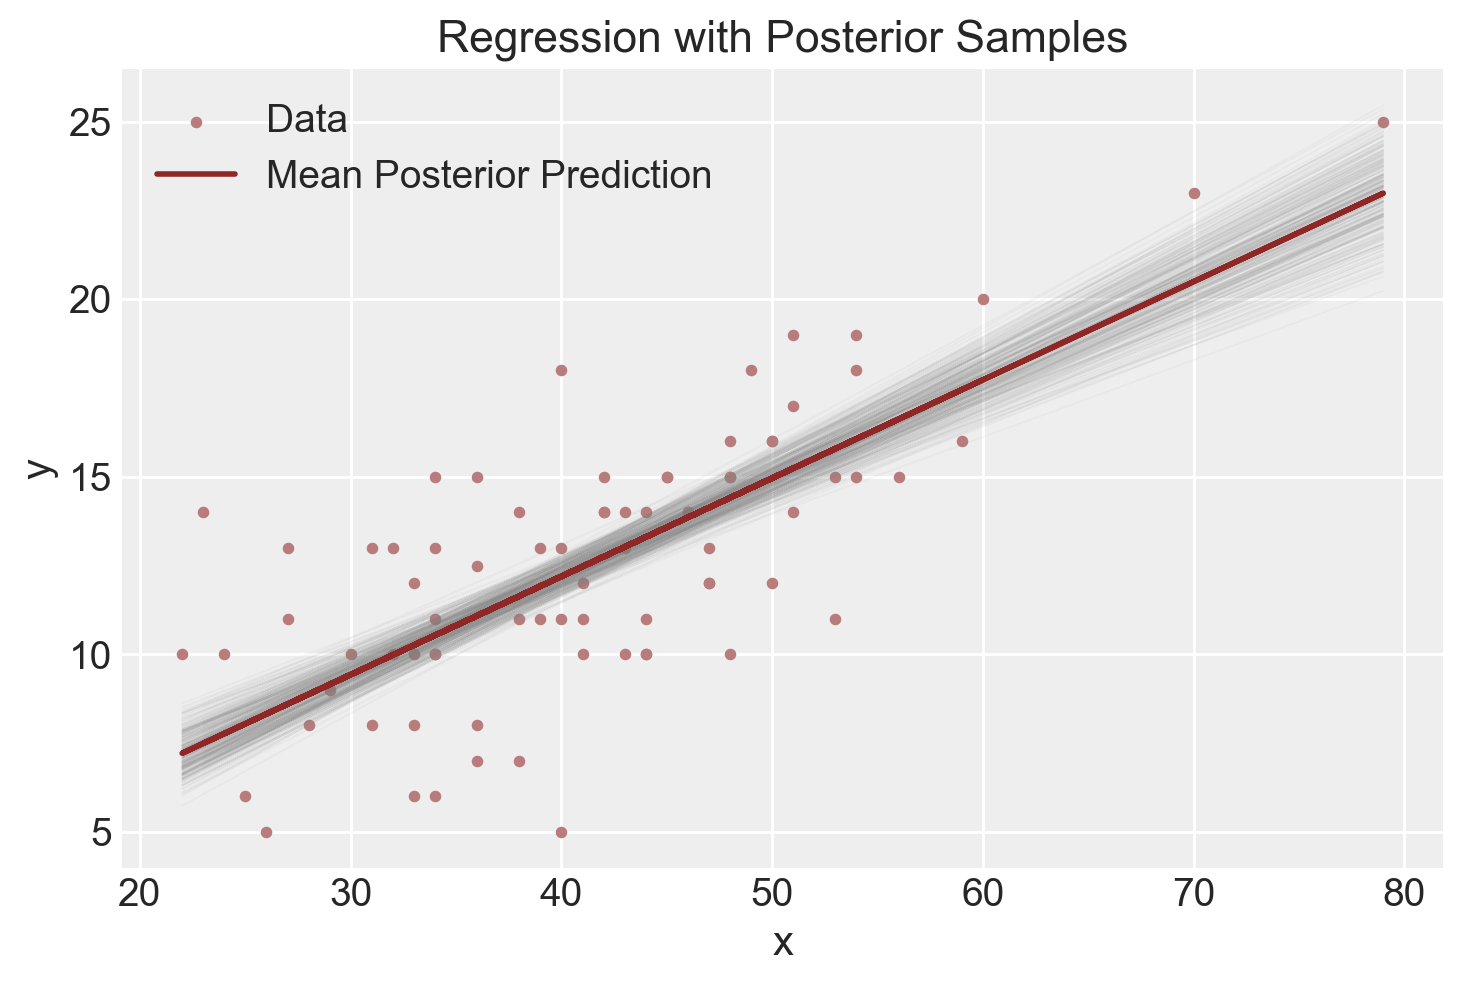

In [96]:
# Plot y vs x
x = df["state1"] 
plt.scatter(
    x, df["TA1"], color=color_fill, label="Data", s=10
)  # s is the size of the point

# Draw lines from posterior samples
for i in range(300):  # assuming you have at least 300 samples
    plt.plot(
        x,
        alpha_samples[i] + beta_samples[i] * x,
        color="gray",
        linestyle="-",
        linewidth=0.5,
        alpha=0.05,
    )

# Line using the mean of posterior estimates
mean_alpha = np.mean(alpha_samples)
mean_beta = np.mean(beta_samples)
color_edge = "#8f2727"
plt.plot(
    x,
    mean_alpha + mean_beta * x,
    color=color_edge,
    linewidth=2,
    label="Mean Posterior Prediction",
)

# Additional plot formatting
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression with Posterior Samples")
plt.legend()
plt.show()

Le numerose linee di regressione presenti nel grafico visualizzano la nostra incertezza riguardo l'inclinazione esatta della linea di regressione principale. Tuttavia, il grafico mostra chiaramente che questa incertezza è minima.

Possiamo procedere in un altro modo per descrivere l'incertezza della stima. Anziché utilizzare le distribuzioni a posteriori di `alpha` e `beta`, possiamo utilizzare la distribuzione a posteriori di `y_rep`. Procedendo in questo modo otteniamo il grafico mostrato qui sotto.

In questo plot, la linea rossa rappresenta la media delle predizioni a posteriori, mentre l'area grigia rappresenta l'intervallo di credibilità al 95%, mostrando l'incertezza delle predizioni del modello. Questo approccio fornisce una visione più completa e realistica dell'incertezza nelle predizioni rispetto all'approccio che utilizza solo `alpha` e `beta`.

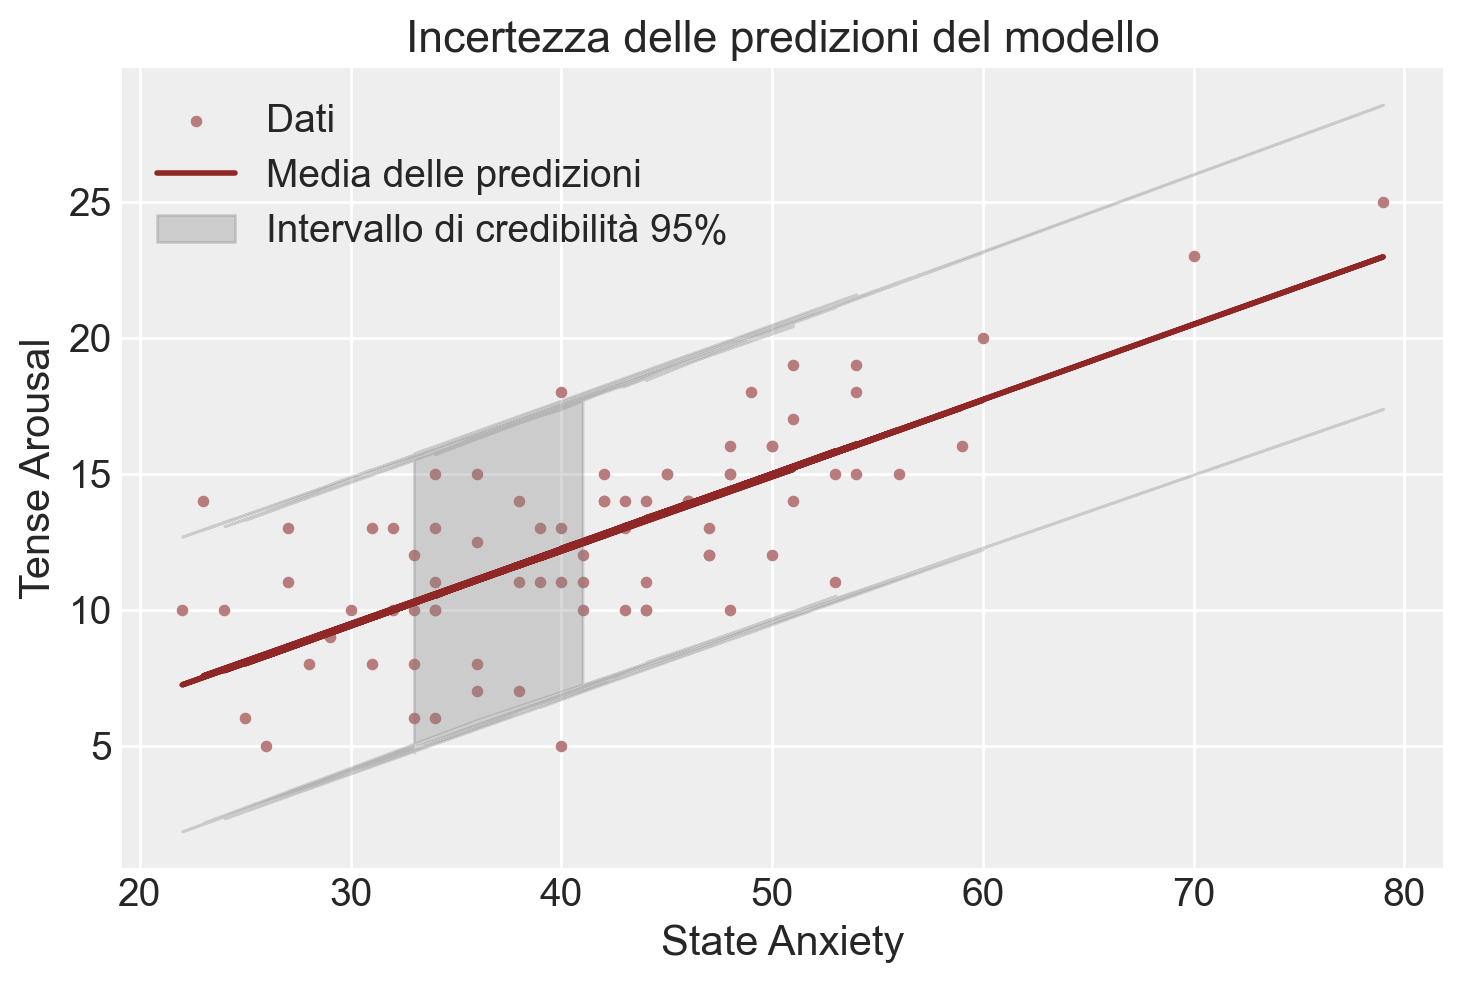

In [97]:
# Estrai i campioni posteriori di y_rep
y_rep_samples = fit3.stan_variable("y_rep")

# Calcola la media e l'intervallo di credibilità (ad esempio, 95%) per y_rep
y_rep_mean = np.mean(y_rep_samples, axis=0)
y_rep_lower = np.percentile(y_rep_samples, 2.5, axis=0)
y_rep_upper = np.percentile(y_rep_samples, 97.5, axis=0)

# Plot y vs x
x = df["state1"]
y = df["TA1"]
plt.scatter(x, y, color=color_fill, label="Dati", s=10)

# Plot della media delle predizioni a posteriori
plt.plot(x, y_rep_mean, color=color_edge, linewidth=2, label="Media delle predizioni")

# Plot dell'intervallo di credibilità
plt.fill_between(
    x,
    y_rep_lower,
    y_rep_upper,
    color="gray",
    alpha=0.3,
    label="Intervallo di credibilità 95%",
)

# Formattazione del plot
plt.xlabel("State Anxiety")
plt.ylabel("Tense Arousal")
plt.title("Incertezza delle predizioni del modello")
plt.legend()
plt.show()

Nel primo approccio, calcoliamo l'incertezza delle predizioni utilizzando le distribuzioni a posteriori di `alpha` e `beta`. Questo metodo consiste nel generare predizioni lineari per ciascun campione a posteriori di `alpha` e `beta`, tracciando quindi le linee di regressione risultanti. Questo ci permette di vedere come varia la linea di regressione in base alle incertezze nei parametri `alpha` e `beta`. Questo metodo visualizza come l'incertezza nei parametri del modello si traduce in incertezza nelle predizioni.

Nel secondo approccio, descriviamo l'incertezza delle predizioni utilizzando direttamente la distribuzione a posteriori di `y_rep`. In questo caso, generiamo predizioni per ciascun valore osservato di `x` nel modello Stan, tenendo conto delle distribuzioni a posteriori dei parametri del modello. Questo metodo visualizza direttamente l'incertezza nelle predizioni, tenendo conto delle variazioni nei dati osservati e delle distribuzioni a posteriori dei parametri.

Le due descrizioni dell'incertezza delle predizioni del modello sono diverse perché riflettono aspetti differenti della distribuzione a posteriori:

1. **Distribuzione a posteriori di `alpha` e `beta`**: Questo approccio considera solo l'incertezza nei parametri del modello (`alpha` e `beta`). Le linee di regressione tracciate variano in base a questi parametri, ma non tengono conto dell'incertezza residua (`sigma`).

2. **Distribuzione a posteriori di `y_rep`**: Questo approccio include non solo l'incertezza nei parametri `alpha` e `beta`, ma anche l'incertezza residua (`sigma`). La distribuzione di `y_rep` riflette la variabilità totale nel modello, inclusa la variabilità nei dati osservati. Pertanto, l'incertezza nelle predizioni è maggiore perché tiene conto di tutte le fonti di variabilità.

Certamente, ecco una versione migliorata del testo:

## Ricodifica dei dati

L'intercetta ($\alpha$) rappresenta il valore atteso di Tense Arousal quando l'ansia di stato è pari a 0. Tuttavia, poiché l'ansia di stato è misurata su una scala ad intervalli, l'origine è arbitraria e non rappresenta l'assenza della proprietà. Lo stesso vale per la variabile Tense Arousal. Per entrambe le variabili, inoltre, anche l'unità di misura è arbitraria.

In queste circostanze, una trasformazione utile è la standardizzazione. La standardizzazione fa sì che il valore 0 corrisponda alla media campionaria e che l'unità di misura sia una deviazione standard.

Quando standardizziamo l'ansia di stato, il valore 0 della variabile standardizzata corrisponde alla media della variabile originale. Dato che la retta di regressione passa per il punto $(\bar{x}, \bar{y})$, utilizzando i valori standardizzati di $x$ e $y$, la nuova intercetta ($\alpha$) sarà 0. La pendenza ($\beta$) avrà un'interpretazione utile: nel caso di dati standardizzati, la pendenza stima l'incremento (o decremento) atteso di $y$ quando $x$ aumenta di una deviazione standard.

In [84]:
# Calcolo della media e della deviazione standard di state1
mean_state1 = np.mean(df["state1"])
std_state1 = np.std(df["state1"])
# Standardizzazione 
df["state1_z"] = (df["state1"] - mean_state1) / std_state1

# Calcolo della media e della deviazione standard di TA1
mean_ta1 = np.mean(df["TA1"])
std_ta1 = np.std(df["TA1"])
# Standardizzazione 
df["ta1_z"] = (df["TA1"] - mean_ta1) / std_ta1

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_11934/3940630615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["state1_z"] = (df["state1"] - mean_state1) / std_state1
/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_11934/3940630615.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ta1_z"] = (df["TA1"] - mean_ta1) / std_ta1


In [85]:
stan_data2 = {"N": len(df["state1_z"]), "x": df["state1_z"], "y": df["ta1_z"]}
print(stan_data2)

{'N': 78, 'x': 0    -0.042127
1    -1.491782
2    -1.008563
3    -1.298494
4     0.537735
        ...   
73   -0.138770
74    1.794103
75   -1.685069
76   -0.815276
77   -0.815276
Name: state1_z, Length: 78, dtype: float64, 'y': 0    -0.424575
1    -1.995334
2    -1.209955
3    -1.209955
4    -0.162782
        ...   
73    0.099012
74    1.931564
75   -0.686368
76   -0.686368
77   -1.733541
Name: ta1_z, Length: 78, dtype: float64}


In [86]:
fit4 = model.sample(
    data=stan_data2,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

In [87]:
az.summary(fit4, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.079,-0.149,0.152,0.001,0.001,8039.0,5594.0,1.0
beta,0.722,0.081,0.564,0.868,0.001,0.001,7720.0,5935.0,1.0
sigma,0.710,0.058,0.604,0.821,0.001,0.000,7766.0,5919.0,1.0


Quando l'ansia di stato aumenta di una deviazione standard Tense Arousal aumenta, in media, di 0.725 deviazioni standard.

## Distribizioni a priori sui parametri

Spefichiamo ora le seguenti distribuzioni a priori debolmente informative sui parametri del modello.

1. **Intercetta ($\alpha$)**:

   - $\alpha \sim \text{Normale}(0, 1)$
   - La scelta di una deviazione standard ampia (2) riflette l'incertezza riguardo al valore iniziale dell'intercetta. Si crede che l'intercetta possa essere qualsiasi valore vicino a 0, ma con una variazione significativa.

2. **Coefficiente Angolare ($\beta$)**:

   - $\beta \sim \text{Normale}(0, 2)$
   - Un'ampia deviazione standard (2) per $\beta$ permette di incorporare l'incertezza riguardo all'influenza della temperatura sui ricavi del gelato. Questo prior permette che $\beta$ possa essere sia positivo che negativo con una vasta gamma di valori.

3. **Deviazione Standard Residua ($\sigma$)**:

   - $\sigma \sim \text{Cauchy}^+(0, 2)$
   - La distribuzione Half-Cauchy è scelta perché è debolmente informativa e adatta per i parametri di scala come la deviazione standard residua. La scala di 2 consente a $\sigma$ di assumere una vasta gamma di valori positivi, riflettendo l'incertezza riguardo alla variabilità residua.

### Interpretazione delle Distribuzioni a Priori

Queste distribuzioni a priori rappresentano le credenze iniziali riguardanti i parametri del modello prima di osservare i dati. Le distribuzioni normali per $\alpha$ e $\beta$ con deviazioni standard ampie permettono una grande flessibilità, mentre la distribuzione Half-Cauchy per $\sigma$ è scelta per la sua capacità di gestire bene i parametri di scala. Queste scelte garantiscono che il modello sia debolmente informativo, permettendo ai dati osservati di avere un'influenza significativa sulle stime posteriori dei parametri.

In [88]:
stan_file = os.path.join(project_directory, "stan", "arousal_model_prior.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // distribuzioni a priori
  alpha ~ normal(0, 2);
  beta ~ normal(0, 2);
  sigma ~ cauchy(0, 2);
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}



Adattiamo il nuovo modello ai dati.

In [89]:
fit5 = model.sample(
    data=stan_data2,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo le distribuzioni a posteriori dei parametri.

In [90]:
az.summary(fit5, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.081,-0.152,0.151,0.001,0.001,8115.0,5652.0,1.0
beta,0.723,0.079,0.576,0.876,0.001,0.001,7440.0,6078.0,1.0
sigma,0.709,0.059,0.603,0.822,0.001,0.000,8278.0,5413.0,1.0


Si noti che, utilizzando distribuzioni a priori debolmente informative, le distribuzioni a posteriori dei parametri risultano molto simili a quelle ottenute usando distribuzioni uniformi. Tuttavia, le distribuzioni a priori debolmente informative sono preferibili poiché forniscono una maggiore stabilità numerica e sono generalmente più affidabili e robuste, specialmente quando si lavora con dati reali. L'uso di distribuzioni uniformi è sconsigliato per via delle possibili instabilità numeriche che possono introdurre nei modelli.

### Posterior-predictive check

Generiamo ora un PPC plot per confrontare le predizioni del modello con i dati osservati.

In [91]:
stan_file = os.path.join(project_directory, "stan", "arousal_model_3.stan")
model = CmdStanModel(stan_file=stan_file)

In [92]:
fit6 = model.sample(
    data=stan_data2,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Per creare un PPC plot dobbiamo creare un oggetto InferenceData nel quale i dati sono strutturati come si aspetta ArviZ:

In [93]:
idata = az.from_cmdstanpy(
    posterior=fit6,
    posterior_predictive="y_rep",
    observed_data={"y": df["ta1_z"]},
)

Avendo generato l'oggetto `idata`, possiamo ora creare il pp-check plot. 

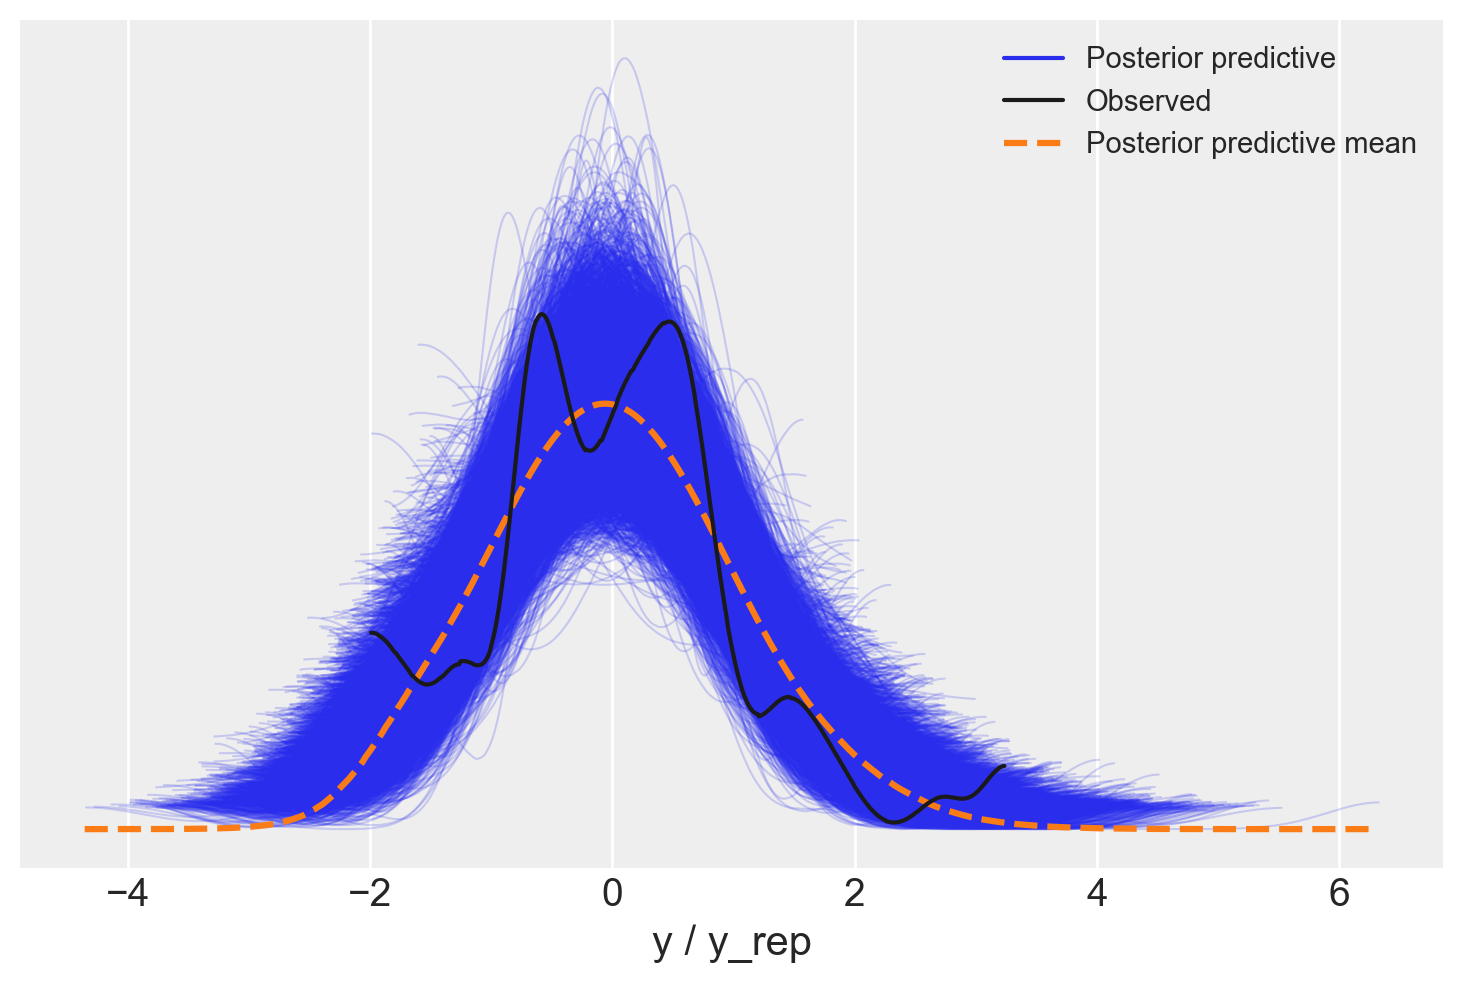

In [68]:
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"}, num_pp_samples=100)

## Verifica della procedura di fitting del modello utilizzando una simulazione con dati fittizi

L'esempio precedente è abbastanza semplice da permetterci di tracciare un grafico e vedere se la linea di regressione attraversa i punti. Tuttavia, in generale, è una buona pratica verificare l'adattamento del modello eseguendo la procedura in condizioni controllate, dove conosciamo la verità. Mostriamo questo approccio utilizzando il modello precedente.

**Passo 1: Creazione di un mondo fittizio.**

Iniziamo assumendo dei valori reali per tutti i parametri del modello. In questo caso, abbiamo già adattato un modello ai dati, quindi procediamo assumendo che questi particolari valori dei parametri siano la verità. In altre parole, assumiamo che la relazione $y = 1.126 + 2.2x + \text{errore}$ sia vera, con gli errori estratti da una distribuzione normale con media 0 e deviazione standard 2.688. Successivamente, utilizzando i valori predittori $x$ già presenti nel nostro dataset, esaminiamo se questi predittori generano una distribuzione di $y$ coerente con i valori osservati di $y$.

In [6]:
a = 1.126	
b = 0.277
sigma = 2.688
x = df["state1"]
n = len(x)

**Passo 2: Simulazione di dati fittizi.**

Successivamente, simuleremo un vettore $y$ di dati fittizi e inseriremo tutto questo in un data frame:

In [8]:
y = a + b * x + np.random.normal(0, sigma, size=n)
fake = pd.DataFrame({"x": x, "y": y})
fake.head()

,x,y
0,41,14.560092
1,26,10.537546
2,31,11.326387
3,28,8.181064
4,47,13.802861


**Passo 3: Adattamento del modello e confronto tra i valori stimati e quelli assunti.**

Il passo successivo è adattare un modello di regressione a questi dati. Durante l'adattamento, non si fa alcun uso dei valori veri assunti di α, β e σ.

In [9]:
lm = pg.linear_regression(fake["x"], fake["y"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.44,1.30,1.11,0.27,0.53,0.52,-1.15,4.03
1,x,0.28,0.03,9.17,0.00,0.53,0.52,0.22,0.34


Le stime ottenute dai dati fittizzi sono molto simili a quelle ottenute con i dati veri.

**Passo 4: Inserire la simulazione in un loop.**

Per ottenere una stima dell'incertezza delle nostre stime, ripetiamo la simulazione molte volte e calcoliamo il livello di copertura dei parametri.

Il livello di copertura rappresenta la proporzione delle volte in cui l'intervallo di confidenza calcolato contiene il vero valore del parametro $b$. In altre parole, se l'intervallo di confidenza al 68% (o 95%) è calcolato correttamente, ci aspetteremmo che, rispettivamente, il 68% (o 95%) di questi intervalli contenga il vero valore di $b$.

- Il codice seguente esegue `n_fake = 10_000` simulazioni, ciascuna delle quali genera un set di dati fittizio e adatta un modello di regressione a questi dati.

- I valori critici `t_68` e `t_95` sono calcolati utilizzando la funzione `t.ppf` di `scipy.stats`, che fornisce i quantili della distribuzione t di Student per il livello di confidenza desiderato:
    - `t_68` corrisponde al quantile dell'84%, che definisce l'intervallo di confidenza al 68%.
    - `t_95` corrisponde al quantile del 97,5%, che definisce l'intervallo di confidenza al 95%.

- Per ogni simulazione (`s` da 0 a `n_fake - 1`):
    - Vengono generati dati fittizi per la variabile indipendente `x` e per la variabile dipendente `y` usando i valori di `a`, `b`, e `sigma`.
    - Viene adattato un modello di regressione lineare ai dati fittizi usando la libreria `pingouin`.
    - Il coefficiente stimato `b_hat` e il suo errore standard `b_se` sono estratti dai risultati della regressione.
    - Viene verificato se il vero valore di $b$ si trova all'interno dell'intervallo $b_hat \pm t_68 \times b_se$.
        - `cover_68[s] = np.abs(b - b_hat) < t_68 * b_se` memorizza `True` (1) se il vero valore di $b$ è all'interno dell'intervallo di confidenza al 68%, altrimenti `False` (0).
   - Viene verificato se il vero valore di $b$ si trova all'interno dell'intervallo $b_hat \pm t_95 \times b_se$.
    - `cover_95[s] = np.abs(b - b_hat) < t_95 * b_se` memorizza `True` (1) se il vero valore di $b$ è all'interno dell'intervallo di confidenza al 95%, altrimenti `False` (0).

Dopo aver completato tutte le simulazioni, i livelli di copertura sono calcolati come la media dei valori in `cover_68` e `cover_95`:

- `cover_68.mean()` fornisce la proporzione di simulazioni in cui l'intervallo di confidenza al 68% ha contenuto il vero valore di $b$.
- `cover_95.mean()` fornisce la proporzione di simulazioni in cui l'intervallo di confidenza al 95% ha contenuto il vero valore di $b$.

Se il risultato è vicino a 0.68, significa che l'intervallo di confidenza al 68% calcolato per ogni simulazione ha contenuto il vero valore di $b$ nel 68% delle simulazioni, come previsto teoricamente.
Se il risultato è vicino a 0.95, significa che l'intervallo di confidenza al 95% calcolato per ogni simulazione ha contenuto il vero valore di $b$ nel 95% delle simulazioni, in linea con le aspettative teoriche.

Se i livelli di copertura risultano sostanzialmente inferiori ai valori teorici (68% e 95%), potrebbe indicare problemi nella stima degli intervalli di confidenza o nelle assunzioni del modello.

In [14]:
from scipy.stats import t

# Parametri della simulazione
n_fake = 10_000  # numero di simulazioni

# Inizializzazione delle liste di copertura
cover_68 = np.zeros(n_fake)
cover_95 = np.zeros(n_fake)

# Calcola i valori critici t per il 68% e il 95% utilizzando scipy.stats.t.ppf
t_68 = t.ppf(0.84, df=n - 2)
t_95 = t.ppf(0.975, df=n - 2)

# Ciclo per la simulazione
for s in range(n_fake):
    x = np.random.normal(size=n)
    y = a + b * x + np.random.normal(0, sigma, size=n)
    fake = pd.DataFrame({"x": x, "y": y})

    # Fit del modello usando pingouin
    fit = pg.linear_regression(fake[["x"]], fake["y"])
    b_hat = fit["coef"][1]
    b_se = fit["se"][1]

    # Calcolo della copertura
    cover_68[s] = np.abs(b - b_hat) < t_68 * b_se
    cover_95[s] = np.abs(b - b_hat) < t_95 * b_se

# Output dei risultati
print(f"68% coverage: {cover_68.mean()}")
print(f"95% coverage: {cover_95.mean()}")

68% coverage: 0.6798
95% coverage: 0.9462


Si noti come la simulazione produce una copertura molto prossima a quella teorica. Ciò significa che, nel caso di questa analisi, possiamo assegnare agli intervalli di confidenza o credibilità l'interpretazione usuale. Se il livello di copertura della simulazione fosse stato inferiore a quello teorico (per modelli più complessi), allora questo sarebbe un'indicazione che si dovrebbero interpetare gli intervalli di confidenza o credibilità con cautela.

## Il Paradosso della Regressione verso la Media

Il fenomeno della regressione verso la media è un concetto statistico importante, spesso frainteso e talvolta interpretato erroneamente come un effetto causale. Questo fenomeno fu osservato inizialmente da Galton in uno studio classico sull'ereditarietà dell'altezza.

@gelman2021regression discutono questo fenomeno analizzando i dati pubblicati nel 1903 da Karl Pearson e Alice Lee. Applicando un modello di regressione lineare a questi dati, si ottiene la seguente equazione:

$$
y = 63.9 + 0.54(x − 62.5) + \text{errore},
$$

dove $y$ rappresenta l'altezza delle figlie e $x$ l'altezza delle madri. La variabile indipendente è stata centrata per evitare interpretazioni prive di senso dell'intercetta.

Il paradosso emerge dal coefficiente di regressione, che è inferiore a 1. Questo implica che:

1. Se una madre ha un'altezza nella media, si prevede che sua figlia adulta avrà anch'essa un'altezza nella media.
2. Per ogni pollice in più (o in meno) rispetto alla media dell'altezza materna, ci si aspetta che la figlia sia circa mezzo pollice più alta (o più bassa) rispetto alla media della sua generazione.

Questo porta a una domanda apparentemente paradossale: se le madri alte tendono ad avere figlie solo leggermente alte, e le madri basse figlie solo leggermente basse, non significa che le figlie saranno più vicine alla media rispetto alle loro madri? E se questo processo continua, non dovremmo aspettarci che dopo poche generazioni tutti abbiano un'altezza vicina alla media?

La risoluzione di questo apparente paradosso sta nel fatto che la previsione dell'altezza di una donna è più vicina alla media rispetto all'altezza di sua madre, ma l'altezza effettiva non è la stessa cosa della previsione, che ha un margine di errore. Le previsioni puntuali regrediscono verso la media - ecco perché il coefficiente è inferiore a 1 - e questo riduce la variazione. Allo stesso tempo, però, l'errore nel modello - l'imperfezione della previsione - aggiunge variazione, sufficiente a mantenere la variazione totale dell'altezza approssimativamente costante da una generazione all'altra.

La regressione verso la media si verifica sempre in qualche forma quando le previsioni sono imperfette in un ambiente stabile. L'imperfezione della previsione induce variazione, e la regressione nella previsione puntuale è necessaria per mantenere costante la variazione totale.

Questo fenomeno è controintuitivo e spesso porta a interpretazioni causali errate. Per chiarire come ciò possa accadere, possiamo considerare uno scenario matematicamente equivalente: studenti che affrontano due esami. Coloro che ottengono punteggi alti nel primo esame tendono a ottenere risultati solo leggermente superiori alla media nel secondo; d'altra parte, chi ottiene punteggi bassi nel primo esame tende a migliorare leggermente, ottenendo risultati nel secondo esame che, pur restando inferiori alla media, non sono così bassi come i primi.

Potrebbe sembrare naturale dare a questo fenomeno una spiegazione causale, suggerendo che gli studenti che eccellono nel primo esame possano avere alte capacità ma poi, diventando troppo sicuri di sé, tendano a rilassarsi, con il risultato di non ripetere la stessa performance nel secondo. Dall'altro lato, si potrebbe ipotizzare che gli studenti con punteggi bassi nel primo esame siano motivati a impegnarsi di più, migliorando così i loro risultati nel secondo.

In realtà, il fenomeno della regressione verso la media si verifica anche in assenza di fattori motivazionali, come dimostrano simulazioni in cui sia il primo che il secondo esame sono determinati dalla vera abilità dell'individuo, più un elemento di rumore casuale. La regressione verso la media è un fenomeno puramente statistico, privo di una spiegazione causale intrinseca. Comprendere correttamente questo concetto è essenziale per evitare di trarre conclusioni errate dai dati.

## Commenti e considerazioni finali

In questo capitolo abbiamo esplorato la stima dei parametri di un modello di regressione bivariato utilizzando l'approccio bayesiano. Per offrire un confronto con un metodo alternativo, in appendice viene presentata un'introduzione all'approccio frequentista per il modello di regressione lineare bivariato. Questa sezione aggiuntiva fornisce una panoramica dei concetti chiave dell'approccio frequentista, permettendo di confrontare e comprendere le differenze tra i due metodi nella stima dei parametri e nell'interpretazione dei risultati. Per chi desidera approfondire questo argomento, consiglio il testo *Applied Regression Analysis and Generalized Linear Models* [@fox2015applied], in particolare il capitolo 2, "Linear Models and Least Squares". In italiano, segnalo anche *Statistica per psicologi* [@caudek2001statistica].

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [69]:
%load_ext watermark
%watermark -n -u -v -iv -m  

Last updated: Tue Jul 30 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.9.1
arviz     : 0.18.0
cmdstanpy : 1.2.4
pandas    : 2.2.2
logging   : 0.5.1.2
pingouin  : 0.5.4
seaborn   : 0.13.2
numpy     : 1.26.4

